In [711]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def tar_simulation(regime_1, regime_2, N, threshold_func, seed=1, tau=0, sd=0, plot=True):
    """
    Simulates a Threshold Autoregressive (TAR) model with two regimes.

    Parameters:
    - regime_1: Coefficients for the first regime [intercept, AR coefficients].
    - regime_2: Coefficients for the second regime [intercept, AR coefficients].
    - N: Number of observations to simulate.
    - threshold_func: Function to determine the threshold condition.
    - seed: Random seed for reproducibility.
    - tau: Threshold value.
    - sd: Standard deviation of the noise added to the process.
    - plot: Boolean to indicate whether to plot the results.

    Returns:
    - y: Simulated time series data.
    - coef_regime1: Estimated coefficients for regime 1.
    - coef_regime2: Estimated coefficients for regime 2.
    """
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Determine AR order based on the longest regime
    d = max(len(regime_1) - 1, len(regime_2) - 1)
    
    # Ensure there are enough lags for the threshold function
    max_lag = max(d, 2)
    
    # Initialize time series array with zeros
    y = np.zeros(N + max_lag, dtype=np.float64)
    
    # Initialize counters for each regime
    regime_count = np.zeros(2, dtype=int)
    
    # Dummy variable to track which regime each observation belongs to
    dummy = np.zeros(N, dtype=int)
    
    # Pre-allocate arrays for regime coefficients (reversed order for dot product)
    regime_1_coef = np.array(regime_1[1:][::-1])
    regime_2_coef = np.array(regime_2[1:][::-1])
    
    # Simulate the time series data
    for i in range(max_lag, N + max_lag):
        # Calculate threshold value using custom function
        threshold_value = threshold_func(y[i-2:i][::-1])
        
        # Determine which regime to use based on threshold value
        if threshold_value <= tau + 1e-8:
            new_value = np.dot(y[i-d:i][::-1][:len(regime_1)-1], regime_1_coef) + regime_1[0]
            regime_count[0] += 1
            dummy[i-max_lag] = 1
        else:
            new_value = np.dot(y[i-d:i][::-1][:len(regime_2)-1], regime_2_coef) + regime_2[0]
            regime_count[1] += 1
        
        # Add noise and update time series
        y[i] = new_value + np.random.normal(0, sd)
    
    # Remove initial zero padding
    y = y[max_lag:]
    
    # Prepare data matrix for OLS estimation (adding constant term)
    X = np.column_stack([np.ones(N-d), *[y[i:N-d+i] for i in range(d)]])
    
    # Dependent variable for OLS estimation
    y_dependent = y[d:]

    # Estimate coefficients for both regimes using OLS
    coef_regime1, coef_regime2 = [], []
    
    for regime in [0, 1]:
        X_regime = X[dummy[d:] == regime]
        y_regime = y_dependent[dummy[d:] == regime]
        
        if len(X_regime) > 0:
            model = LinearRegression().fit(X_regime[:, :len(regime_1 if regime == 0 else regime_2)], y_regime)
            coef = np.concatenate([[model.intercept_], model.coef_[1:][::-1]])
            if regime == 0:
                coef_regime1 = coef
            else:
                coef_regime2 = coef
        else:
            print(f"No samples found for Regime {regime + 1}.")
    
    # Plot results if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(X[dummy[d:] == 0, 1], y_dependent[dummy[d:] == 0], color='blue', label='Regime 1')
        plt.scatter(X[dummy[d:] == 1, 1], y_dependent[dummy[d:] == 1], color='orange', label='Regime 2')
        plt.axhline(y=tau, color='red', linestyle='--', label=f'Threshold (tau={tau+1e-8})')
        plt.xlabel('y(t-1)')
        plt.ylabel('y(t)')
        plt.legend()
        plt.title('TAR Model Simulation')
        plt.show()
    
    print("Regime counts:", dict(zip(['Regime_1', 'Regime_2'], regime_count)))
    print("Estimated coefficients for Regime 1:", coef_regime1)
    print("Estimated coefficients for Regime 2:", coef_regime2)
    
    return y, coef_regime1, coef_regime2, dummy




In [712]:
import numpy as np
from scipy.stats import bernoulli
from numba import jit

@jit(nopython=True)
def evaluate_performance(y, x, q):
    """
    Evaluate the performance of a binary classifier using least squares regression.

    Args:
        y (np.ndarray): Target binary outcomes.
        x (np.ndarray): Binary classifier predictions.
        q (int): Lag order for the regression.

    Returns:
        float: Sum of squared residuals from the regression.
    """
    T = len(y)
    # Create design matrix Y for regression
    Y = np.zeros((T-q, q+1))
    Y[:, 0] = 1  # Intercept term
    for i in range(1, q+1):
        Y[:, i] = y[q-i:T-i]  # Lagged values of y
    
    # Estimate coefficients for two models (k=0 and k=1)
    phi = np.zeros((2, q+1))
    for k in range(2):
        mask = (x[:] == k)
        Y_k = Y[mask]
        y_k = y[q:][mask]
        phi[k] = np.linalg.lstsq(Y_k, y_k)[0]
    
    # Calculate and return sum of squared residuals
    residuals = y[q:] - np.sum(Y * phi[x[:]], axis=1)
    return np.sum(residuals**2), phi


def estimate_hidden_states(y, q, N, rho, omega, max_iter=100, tol=1e-6):
    """
    Estimate hidden states using a genetic algorithm approach.

    Args:
        y (np.ndarray): Target binary outcomes.
        q (int): Lag order for the regression.
        N (int): Number of samples to generate in each iteration.
        rho (float): Quantile threshold for selecting elite samples.
        omega (float): Mixing factor for updating probabilities.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.

    Returns:
        np.ndarray: Estimated hidden binary states (0 or 1).
    """
    T = len(y)-q
    p = np.full(T, 0.5)  # Initialize probabilities
    gammas = [0]*10
    for _ in range(max_iter):
        # Generate samples and evaluate performance
        X = bernoulli.rvs(p, size=(N, T))
        S = np.array([evaluate_performance(y, x, q)[0] for x in X])
        # Select elite samples
        gamma = np.percentile(S, rho * 100)
        gammas.append(gamma)
        elite_samples = X[S <= gamma]
        
        # Update probabilities
        p_new = np.mean(elite_samples, axis=0)
        p = omega * p_new + (1 - omega) * p
        # For monitoring convergence
        
        # Check for convergence
        if (np.all(np.abs(p - 0.5) > 0.5 - tol)) or (gammas[-1] == gammas[-2] == gammas[-3] == gammas[-4]):
            # print(_)
            return np.append([np.nan]*q, (p > 0.5).astype(int)), np.append([np.nan]*q, p), evaluate_performance(y, X[S==min(S)][0], q)
            break
        
        # print(_)
    
    return np.append([np.nan]*q, (p > 0.5).astype(int)), np.append([np.nan]*q, p), evaluate_performance(y, X[S==min(S)][0], q)



def informative_states(prob, pi, y):
    """
    Identify informative states based on probability values and a retention criterion.

    This function selects a subset of states considered informative based on their
    probability values and a specified retention ratio. It uses entropy as a measure
    of informativeness and returns binary indicators for the selected states.

    Parameters:
    ----------
    prob : np.ndarray
        An array of probabilities for different states.
    pi : float
        The retention ratio, determining the proportion of states to keep.
    y : np.ndarray
        A target array used for determining the number of retained states.
    q : integer
        The order of the autoregressive process. Due to the loss of the first q observations in AR(q) we have to add them to index.

    Returns:
    -------
    np.ndarray
        An array of binary values indicating informative states, where 1 indicates
        the state is considered informative (probability > 0.5) and 0 otherwise.

    Notes:
    -----
    - The function uses entropy (prob * (1 - prob)) as a measure of informativeness.
    - Lower entropy values are considered more informative.
    - The number of retained states is calculated as ceil(pi * len(y)).
    """
    # Calculate the number of states to retain
    retained = np.ceil(pi * len(y)).astype(int)

    # Calculate the entropy of each state
    entropy = prob * (1 - prob)

    # Get the indices of the retained states (lowest entropy)
    indices = np.argpartition(entropy, retained)[:retained]

    # Sort the indices to maintain original order
    sorted_indices = np.sort(indices)

    # Return binary indicators for the retained states align it with index of the original series y:
    # you have 2 minus q when you want to slice state_est
    return np.sort(indices)

def label_switch(est, dummy):
    return est if np.sum(est == dummy)>np.sum(est == 1-dummy) else 1 - est
    

# TAR Simulation

### Parameter setup

In [713]:
# Define a custom threshold function for switch
def custom_threshold(y):
    return y[0]

# Coefficients
regime_1 = [2, 0.5, 0.5]
regime_2 = [-2, -2, 0.3]

# Number of observations
N = 400

### Simulate a two-state TAR model

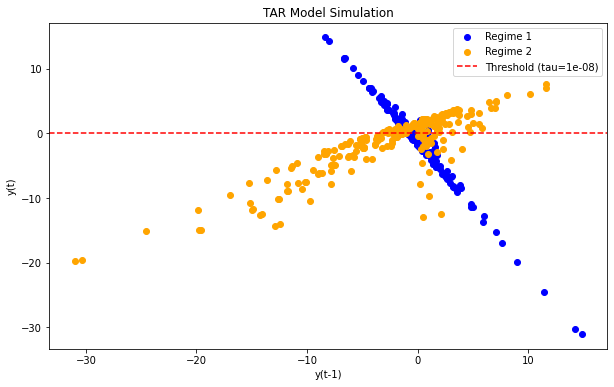

Regime counts: {'Regime_1': 227, 'Regime_2': 173}
Estimated coefficients for Regime 1: [-2.   0.3 -2. ]
Estimated coefficients for Regime 2: [2.  0.5 0.5]


In [714]:
# Simulate TAR
y, coef_regime1, coef_regime2, dummy = tar_simulation(regime_1, regime_2, N, custom_threshold, tau=0, sd=0)

# Data Split and Classification Stage

In [715]:
# %timeit
# Train, Validation and Test Sets
y_train = y[:100]
y_valid = y[100:200]
y_test = y[200:]

# True states in train set to check validity
dummy_train = dummy[:100]

# Apply CE estimation to the first 100 observations
res = estimate_hidden_states(y_train, 2, 30*len(y_train), 0.01, 0.6, max_iter=100, tol=1e-6)

# Align the estimated labels with the originals
state_est = label_switch(res[0], dummy_train)
print(state_est==dummy_train) # There should be q differences in the first two positions due to loss of observations

# Get informative states indices for the test set
prob_train = res[1][:100]
informative_indices = informative_states(prob_train, 0.2, y_train)

# Check correct alignment of informative states:
dummy[informative_indices] == state_est[informative_indices]

[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

# Data Process for Search Stage

In [716]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Step 1: Create features from the time series y
def create_features(y):
    features = pd.DataFrame({
        '3Yt-3 - 2Y^2_t-2': 3*y.shift(3) - 2*y.shift(2)**2,
        'Yt-1': y.shift(1),
        'Yt-2': y.shift(2),
        'Yt-3': y.shift(3),
        'Yt-4': y.shift(4),
        'Y^3_t-1 - 13Yt-2 + 14': y.shift(1)**3 - 13*y.shift(2) + 14,
        'Y^2_t-2 - 11Yt-3 + 77': y.shift(2)**2 - 11*y.shift(3) + 77,
        'Y^3_t-3 - 17Yt-4 + 66': y.shift(3)**3 - 17*y.shift(4) + 66,
        '5U[1,0]': np.random.uniform(1, 0, len(y)) * 5,
        '2N(0,1) + 3U[0,1]': 2*np.random.normal(0, 1, len(y)) + 3*np.random.uniform(0, 1, len(y)),
        'Y^4_t-1 + 2Yt-1 + 8N(0,1)': y.shift(1)**4 + 2*y.shift(1) + 8*np.random.normal(0, 1, len(y)),
        'Y^4_t-3 + 3Yt-3 + 4N(0,1)': y.shift(3)**4 + 3*y.shift(3) + 4*np.random.normal(0, 1, len(y)),
        'Y^3_t-1 + 4Yt-1 + 3N(0,1)': y.shift(1)**3 + 4*y.shift(1) + 3*np.random.normal(0, 1, len(y)),
        'Y^2_t-2 + 5Yt-3 + 6N(0,1)': y.shift(2)**2 + 5*y.shift(3) + 6*np.random.normal(0, 1, len(y)),
        'Y^2_t-3 + 6Yt-3 + 7N(0,1)': y.shift(3)**2 + 6*y.shift(3) + 7*np.random.normal(0, 1, len(y)),
        'Y^2_t-2 + 7Yt-2 + 4N(0,1)': y.shift(2)**2 + 7*y.shift(2) + 4*np.random.normal(0, 1, len(y)),
        'Y^3_t-3 + 8Yt-3 + 8N(0,1)': y.shift(3)**3 + 8*y.shift(3) + 8*np.random.normal(0, 1, len(y)),
        'Y^3_t-3 + 9Yt-3 + 3N(0,1)': y.shift(3)**3 + 9*y.shift(3) + 3*np.random.normal(0, 1, len(y)),
        'Y^3_t-3 + 10Yt-3 + 2N(0,1)': y.shift(3)**3 + 10*y.shift(3) + 2*np.random.normal(0, 1, len(y)),
        'Y^2_t-2 + 11Yt-2 + 4N(0,1)': y.shift(2)**2 + 11*y.shift(2) + 4*np.random.normal(0, 1, len(y))
    })
    return features

# Create features of length 400:
X = create_features(pd.Series(y))
X_valid = X.iloc[100:200]
X_test = X.iloc[200:]
states_true_valid = dummy[100:200]
states_true_test = dummy[200:]

# # States
states_retained = pd.Series(state_est[informative_indices])
X_retained = X.iloc[informative_indices]
X_retained.reset_index(inplace=True)
X_retained = X_retained.drop(columns=["index"])

# Perform checks
print(state_est[informative_indices]==dummy[informative_indices])
X_valid.shape, X.shape, states_true_test.shape, states_true_valid.shape

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


((100, 20), (400, 20), (200,), (100,))

# DT algorithm

In [717]:
# Step 2: Fit decision tree using cost-complexity pruning and time series validation
def fit_optimal_tree(X_retained, states_retained, X_valid):
    # Fit the initial tree
    clf = DecisionTreeClassifier(random_state=42, criterion="entropy", splitter="best")
    path = clf.cost_complexity_pruning_path(X_retained, states_retained)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    # Train trees with different alphas
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_retained, states_retained)
        clfs.append(clf)
    
    # Validate and choose the best alpha
    acc_scores = [accuracy_score(states_true_valid, clf.predict(X_valid)) for clf in clfs]
    best_alpha_idx = np.argmax(acc_scores)
    
    return clfs[best_alpha_idx]

# Fit the optimal tree
optimal_tree = fit_optimal_tree(X_retained, states_retained, X_valid)

# Step 3: Forecast the test set
y_pred_test = optimal_tree.predict(X_test)

# Print feature importances
importances = pd.Series(optimal_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(importances)

# Print test set accuracy (assuming you have true labels for the test set)
# y_true_test = ...  # True labels for test set
# test_accuracy = accuracy_score(y_true_test, y_pred_test)
# print(f"Test Set Accuracy: {test_accuracy}")

# If you don't have true labels for the test set, you can just print the predictions
print("Test Set Predictions:")
print(y_pred_test)

Feature Importances:
Yt-1                          1.0
3Yt-3 - 2Y^2_t-2              0.0
Y^3_t-3 + 10Yt-3 + 2N(0,1)    0.0
Y^3_t-3 + 9Yt-3 + 3N(0,1)     0.0
Y^3_t-3 + 8Yt-3 + 8N(0,1)     0.0
Y^2_t-2 + 7Yt-2 + 4N(0,1)     0.0
Y^2_t-3 + 6Yt-3 + 7N(0,1)     0.0
Y^2_t-2 + 5Yt-3 + 6N(0,1)     0.0
Y^3_t-1 + 4Yt-1 + 3N(0,1)     0.0
Y^4_t-3 + 3Yt-3 + 4N(0,1)     0.0
Y^4_t-1 + 2Yt-1 + 8N(0,1)     0.0
2N(0,1) + 3U[0,1]             0.0
5U[1,0]                       0.0
Y^3_t-3 - 17Yt-4 + 66         0.0
Y^2_t-2 - 11Yt-3 + 77         0.0
Y^3_t-1 - 13Yt-2 + 14         0.0
Yt-4                          0.0
Yt-3                          0.0
Yt-2                          0.0
Y^2_t-2 + 11Yt-2 + 4N(0,1)    0.0
dtype: float64
Test Set Predictions:
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 

In [718]:
y_pred_test == dummy[-200:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,